<a href="https://colab.research.google.com/github/jacomyma/dtu-sts-material/blob/main/notebooks/colab/Semantic_map_Filter_and_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic map - Filter and render

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Filter the map using a condition (a **query**)
- Render the semantic map as a static image

**How to use**:
- Edit settings if you want
- Then use "Runtime > Run all" or execute from the edited cell and below
- Wait for each cell to run
- ⚠️ Allow the script to access your Google Drive data when prompted to.
- **Edit the query** as you see fit
- Re-run that cell and the following ones to update the visualization


## Settings

In [ ]:
# SETTINGS (edit if necessary)
settings = {}
settings['use_neutral_background'] = False

## Code

(You don't have to understand what's going on here, but feel free to take a look)

In [ ]:
# Additional settings you shouldn't have to change
settings['statements_spreadsheet_drive_URL'] = 'https://docs.google.com/spreadsheets/d/1cSwVVXAB7kYRbGKEr6gc5IGs955dIfJNcCzyl_cywa8/edit?usp=drive_link'
settings['pic_background_URL'] = 'https://drive.google.com/file/d/1qGYOnXgkF6d3PfeviE3af6EdJdzpFdz-/view?usp=drive_link'

### Install stuff
Note: already installed libraries will not be reinstalled, don't worry about re-running that.

In [ ]:
!pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2

In [ ]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from PIL import Image, ImageDraw

### Load data from the corpus

In [ ]:
# Open the spreadsheet by its key or URL
spreadsheet_key = settings['statements_spreadsheet_drive_URL'].split('/d/')[1].split('/edit')[0]
sh = gc.open_by_key(spreadsheet_key)

# Select the worksheet
worksheet_name = 'dataset'
worksheet = sh.worksheet(worksheet_name)

In [ ]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0])

# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

# Display dataframe for monitoring purposes
#df
print('Data loaded.')

Data loaded.


### Other prep we need

In [ ]:
# Load the background image
import gdown
import os

# Get the Google Drive file ID from the URL
file_id = settings['pic_background_URL'].split('/d/')[1].split('/view')[0]

# Define the local path to save the downloaded image
local_image_path = 'background_image.png' # You can choose a different name and extension

# Download the file from Google Drive
gdown.download(id=file_id, output=local_image_path, quiet=False)

# Open the downloaded image file
imageBackground = Image.open(local_image_path)

print('\nBackground image loaded.')

# Display dimensions
width, height = imageBackground.size
print("Background image dimensions:", width, 'px x', height, 'px')

Downloading...
From: https://drive.google.com/uc?id=1qGYOnXgkF6d3PfeviE3af6EdJdzpFdz-
To: /content/background_image.png
100%|██████████| 20.1M/20.1M [00:00<00:00, 41.4MB/s]


Background image loaded.
Background image dimensions: 5403 px x 3720 px


In [ ]:
# Compute graphic scales
# Note: this was generated from another notebook.
# It must match how the background image was generated.

x_bary = 6.29654424364498
y_bary = 0.05623316156829829
x_min = -2428.649658
x_max = 1923.094727
y_min = -1392.690308
y_max = 1842.373657
width_px = 5403
height_px = 3720
margin_left_px = -354
margin_right_px = -354
margin_top_px = -354
margin_bottom_px = -354

def computeScales(x_bary, y_bary, x_min, x_max, y_min, y_max, width_px, height_px, margin_left_px, margin_right_px, margin_top_px, margin_bottom_px):

    # Compute the scaling ratio
    scalingRatio = 2 * max(x_max-x_bary, x_bary-x_min, y_max-y_bary, y_bary-y_min) / (min(width_px-margin_left_px-margin_right_px, height_px-margin_top_px-margin_bottom_px))

    def xScale(x):
        # Center on zero
        x = x - x_bary

        # Rescale
        x = x / scalingRatio

        # Center on the center of the canvas
        x = x + width_px/2
        return x

    def yScale(y):
        y = y - y_bary
        y = y / scalingRatio
        y = y + height_px/2
        return y

    def sizeScale(size):
        return size / scalingRatio

    def xUnscale(x):
        x = x - width_px/2
        x *= scalingRatio
        x += x_bary
        return x

    def yUnscale(y):
        y = y - height_px/2
        y *= scalingRatio
        y += y_bary
        return y

    def sizeUnscale(size):
        return size * scalingRatio


    return xScale, yScale, sizeScale, xUnscale, yUnscale, sizeUnscale

xScale, yScale, sizeScale, xUnscale, yUnscale, sizeUnscale = computeScales(x_bary, y_bary, x_min, x_max, y_min, y_max, width_px, height_px, margin_left_px, margin_right_px, margin_top_px, margin_bottom_px)

In [ ]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Filtering condition (QUERY)

**Edit the condition (the query)**, then run this cell and those below to update them. Also give a title to your query for clarity.

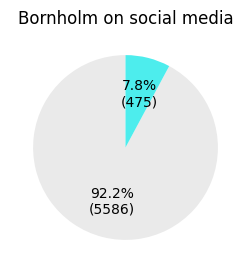

In [ ]:
# EDIT ME
condition = (
    (df['Statement'].str.contains('Bornholm', case=False, na=False))
  & (df['Source type'] == "Social media")
)

# EDIT ME (give an appropriate title to the query)
title = "Bornholm on social media"

# Check that it works
visualize(condition, title)

# Render the semantic map

Rendered image:
(Note that a downloadable high-resolution JPEG image was generated as 'Filtered semantic map.jpg')



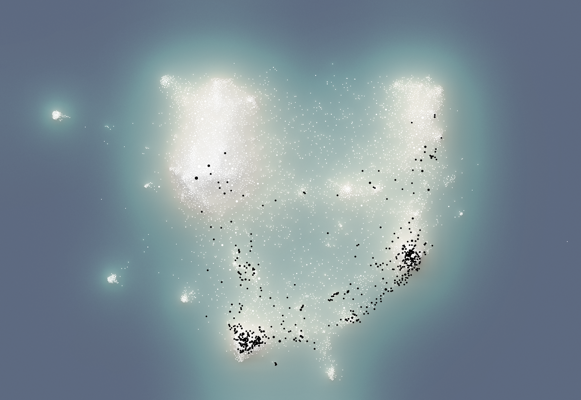

In [ ]:
# Paint nodes over the background

# Init image
if settings['use_neutral_background']:
  # Init image filled with neutral gray
  image = Image.new('RGB', (width, height), color='#DDDDDD')
else:
  image = imageBackground.copy()

# Create a drawing object
draw = ImageDraw.Draw(image)

# First, paint all dots in white (as a background)
for index, row in df.iterrows():
  color = "#FFFFFF"
  x = round(xScale(row['X']))
  y = round(yScale(-row['Y']))
  size = round(sizeScale(row['Size']))
  draw.ellipse((x-size, y-size, x+size, y+size), fill=color)

# Second, paint only a selection of dots in black
df_filtered = df[condition]
# For each row, draw a dot using columns X, Y, and Size
for index, row in df_filtered.iterrows():

  color = "#000000" # Black color
  sizeOffset = 4 # Additional radius for emphasis
  x = round(xScale(row['X']))
  y = round(yScale(-row['Y']))
  size = round(sizeScale(row['Size'])) + sizeOffset
  draw.ellipse((x-size, y-size, x+size, y+size), fill=color)

# Save image in full definition JPEG
rendered_image_file_name = "Filtered semantic map.jpg"
image.save(rendered_image_file_name)

# Display image
thumbnailHeight = 400
resized_image = image.resize((round(width*thumbnailHeight/height), round(thumbnailHeight)), resample=Image.Resampling.BICUBIC)
print("Rendered image:")
print(f"(Note that a downloadable high-resolution JPEG image was generated as '{rendered_image_file_name}')")
print()
display(resized_image.convert("RGB"))